## Feature Importance and Selection
* Sangwon Baek
* March 10th, 2023

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, norm, mannwhitneyu, chi2_contingency, fisher_exact, ttest_ind, zscore

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, ParameterGrid, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time 
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from statsmodels.stats import contingency_tables

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

from sklearn.metrics import f1_score
from interpret.blackbox import LimeTabular
from interpret import show
import shap

import warnings
warnings.filterwarnings("ignore")

C:\Users\user\anaconda3\envs\swb_env_3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read csv file using pandas
df2 = pd.read_csv('../Data/Preprocessed/CRF_DD_removed.csv', low_memory=False)
df2 = df2.drop(columns='Unnamed: 0')

na_cols = ['UD_HT','UD_DM','UD_CVD','UD_cancer','UD_other','SMT_fever','SMT_cough','SMT_sputum','SMT_dyspnea',
          'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid']
df2[na_cols] = df2[na_cols].fillna(value=0)

#Remove D-Dimer from the dataframe
ColumnNames = ['No', 'ID', 'age', 'sex', 'dx_date', 'hospitalized_date', 'UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer',
              'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
              'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 
               'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3', 'BT', 'SBP', 
               'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 
               'DD', 'PCR', 'steroid', 'Mild','Moderate','Severe']
df2 = df2[ColumnNames].drop(columns = 'DD')

# Replace 'UD_' and 'SMT_' in the column names
new_column_names = {col: col.replace('UD_', '').replace('SMT_', '') for col in df2.columns}
# Rename the columns in the dataframe
df2 = df2.rename(columns=new_column_names)

#Separate DF into validation and developmentsets
DevelopmentSet = df2.loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
ValidationSet = df2.loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

drop_columns_original = ['hospitalized_date', 'Mild','Moderate','Severe', 'dx_date', 'No', 'ID', 'PCR', 'steroid', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3']

#Convert the train and test dataset into X and Y
DevelopmentSet_X = DevelopmentSet.drop(columns=drop_columns_original)
DevelopmentSet_Y = DevelopmentSet[['Severe']]

#Development Set split into Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(DevelopmentSet_X, DevelopmentSet_Y, test_size=0.2, random_state=0)

#Standardize the dataset through standardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest model

In [3]:
#Random Forest model (hyperparamter-tuned XGB through HyperOPT): {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 267}
rf_model = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2', min_samples_split=2, n_estimators = 267, random_state=0).fit(X_train, Y_train)
rf_y_pred = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, rf_y_pred)
auc_rf = auc(fpr_rf, tpr_rf)
print(auc_rf)

0.9100544616673649


### Feature Importance Random Forest

In [4]:
feature_names = [item for item in DevelopmentSet_X.columns]
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

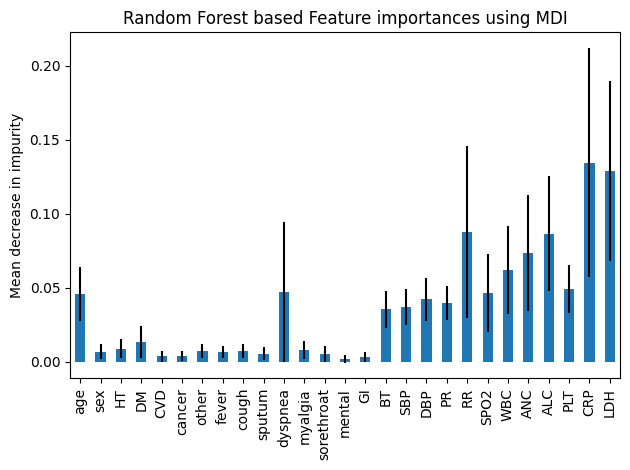

In [6]:
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Random Forest based Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('../Result/Tables_Figures/New/rf_mdi_fi.png', dpi=600)

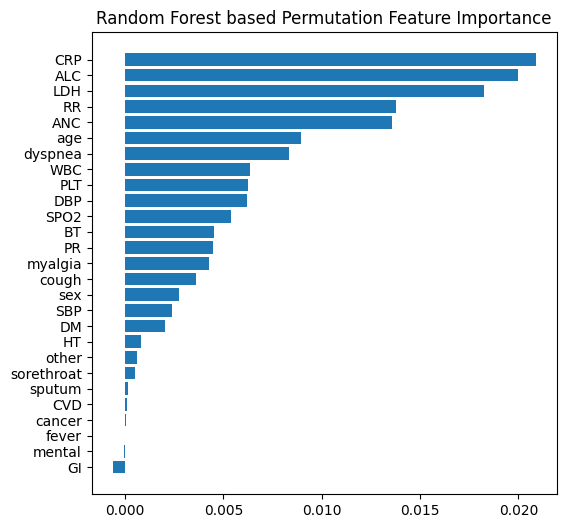

In [7]:
perm_importance = permutation_importance(rf_model, X_test, Y_test, n_repeats=100)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(6,6))
plt.title('Random Forest based Permutation Feature Importance') 
plt.barh(DevelopmentSet_X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.savefig('../Result/Tables_Figures/New/rf_pfi.png', dpi=600)

### Random Forest Based Shapley 

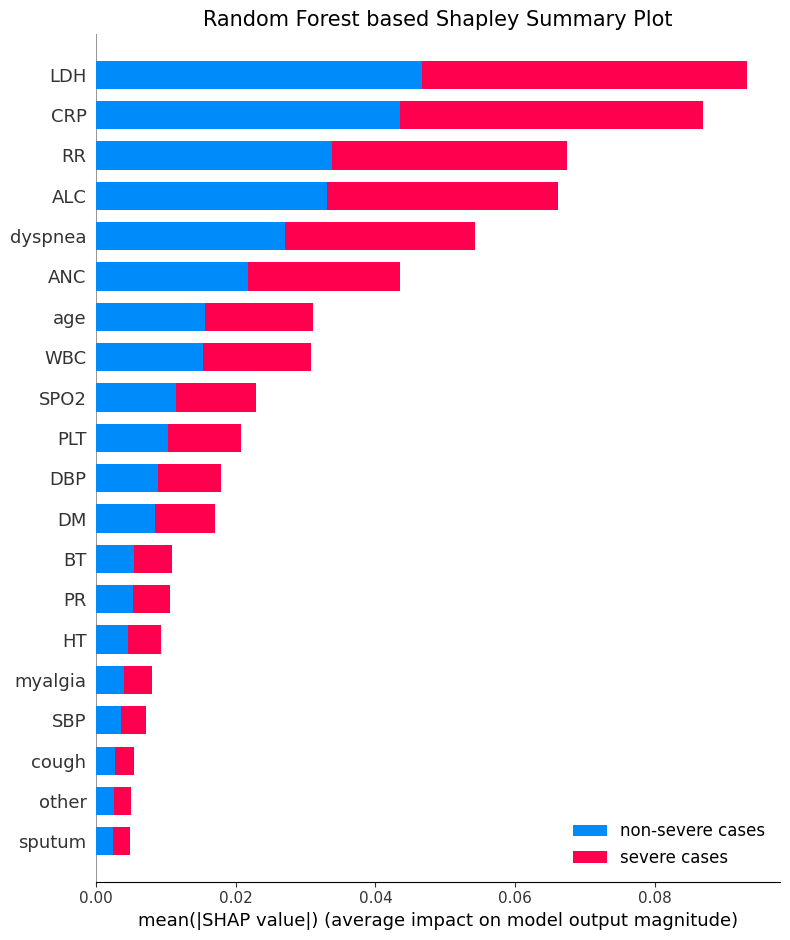

In [7]:
# Feature summary
shap.initjs()
plt.figure(figsize=(6, 6))
explainer_1 = shap.TreeExplainer(rf_model)
shap_values_1 = explainer_1.shap_values(X_test)
plt.title('Random Forest based Shapley Summary Plot', fontsize=15)
shap.summary_plot(shap_values_1, DevelopmentSet_X, show=False, plot_type='bar', class_names=['non-severe cases', 'severe cases'])
plt.savefig('../Result/Tables_Figures/New/rf_shap_summary_plot.png', dpi=600)
plt.show()

### Feature Importance XGBoosting

In [9]:
#XGBoost Model (hyperparamter-tuned XGB through HyperOPT): {'colsample_bytree': 0.4, 'eta': 0.2, 'gamma': 0.75, 'learning_rate': 0.45, 'max_depth': 18, 'min_child_weight': 14, 'nthread': 6}
xgb_model_fi = XGBClassifier(colsample_bytree=0.4, eta=0.2, gamma=0.2, learning_rate=0.45, max_depth=18, min_child_weight=14, nthread=6, random_state=0).fit(DevelopmentSet_X, DevelopmentSet_Y)


<Figure size 600x600 with 0 Axes>

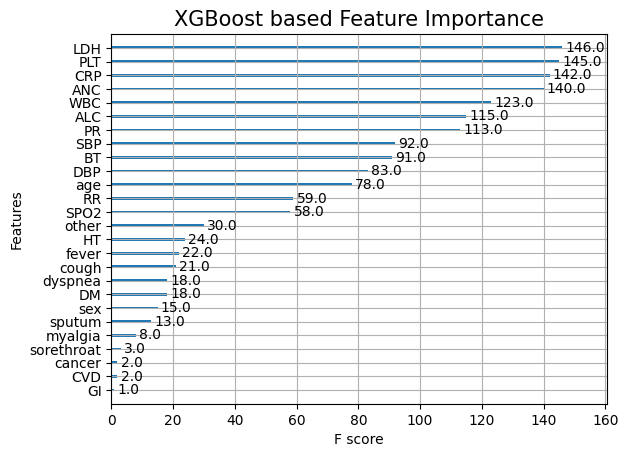

In [10]:
plt.figure(figsize=(6, 6))
plot_importance(xgb_model_fi)
plt.title('XGBoost based Feature Importance', fontsize=15)
plt.savefig('../Result/Tables_Figures/New/xgb_fi.png', dpi=300)

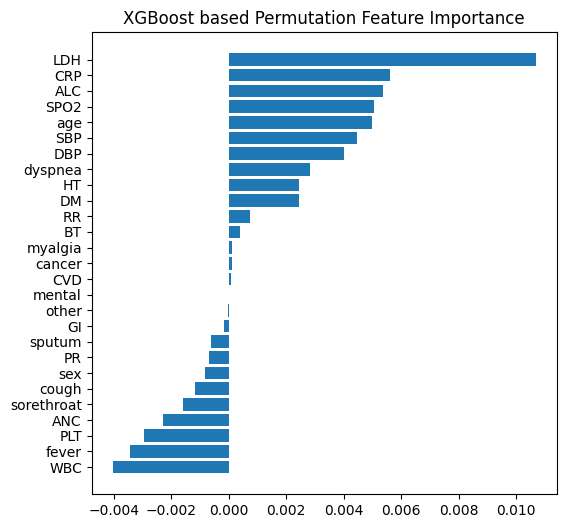

In [11]:
#XGBoost Model (hyperparamter-tuned XGB through HyperOPT): {'colsample_bytree': 0.4, 'eta': 0.2, 'gamma': 0.75, 'learning_rate': 0.45, 'max_depth': 18, 'min_child_weight': 14, 'nthread': 6}
xgb_model = XGBClassifier(colsample_bytree=0.4, eta=0.2, gamma=0.2, learning_rate=0.45, max_depth=18, min_child_weight=14, nthread=6, random_state=0).fit(X_train, Y_train)
perm_importance_XGB = permutation_importance(xgb_model, X_test, Y_test, n_repeats=100)
sorted_idx_XGB = perm_importance_XGB.importances_mean.argsort()
plt.figure(figsize=(6,6))
plt.title('XGBoost based Permutation Feature Importance') 
plt.barh(DevelopmentSet_X.columns[sorted_idx_XGB], perm_importance_XGB.importances_mean[sorted_idx_XGB])
plt.savefig('../Result/Tables_Figures/New/xgb_pfi.png', dpi=600)

### XGB based Shapley

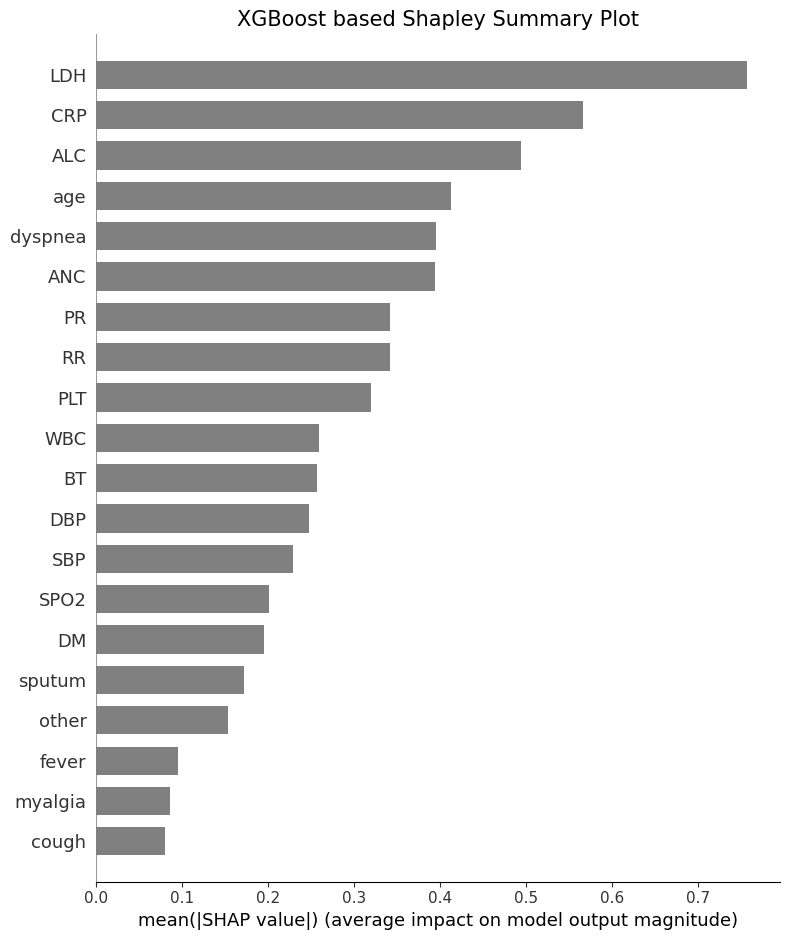

In [17]:
# Feature summary
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(6, 6))
plt.title('XGBoost based Shapley Summary Plot', fontsize=15)
shap.summary_plot(shap_values, DevelopmentSet_X, show=False, plot_type='bar', color=['gray'])
plt.savefig('../Result/Tables_Figures/New/xgb_shap_summary_plot.png', dpi=600)
plt.show()

### LIME explainable AI

In [12]:
y_pred2 = rf_model.predict(X_test)
print("DF2 Accuracy score: {:.4F}".format(accuracy_score(Y_test,y_pred2)))
print("DF2 F1 score: {:.4F}".format(f1_score(Y_test,y_pred2)))

DF2 Accuracy score: 0.8995
DF2 F1 score: 0.6316


In [13]:
lime = LimeTabular(predict_fn = rf_model.predict_proba,
                   data = DevelopmentSet_X, random_state = 0)
#Local explanation for 20 data points
lime_local = lime.explain_local(X_train[-20:], Y_train[-20:], name='LIME')
show(lime_local)

TypeError: __init__() missing 1 required positional argument: 'model'